In [174]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
import talib as ta  # Using TA-Lib instead of pandas_ta

# Set device for PyTorch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def download_stock_data(ticker, start_date, end_date):
    # Download stock data using yfinance
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def get_high_interest_tickers(min_volume=1000000, min_option_interest=1000, max_stocks=20):
    """
    Find stocks with high trading volume and significant options interest, focusing on mid-cap stocks with higher volatility.
    """
    print("\n=== Stock Screening Started ===")
    
    # High-growth Tech and Software
    tech_stocks = [
        'AMD', 'NVDA', 'CRWD', 'NET', 'SNOW', 'DDOG', 'PLTR', 'UBER', 'LYFT', 'SNAP',
        'ROKU', 'SHOP', 'ZS', 'OKTA', 'FTNT', 'PANW', 'AFRM', 'MSTR', 'COIN', 'RBLX'
    ]
    
    # Biotech and Healthcare Growth
    biotech_stocks = [
        'MRNA', 'BNTX', 'CRSP', 'BEAM', 'EDIT', 'NVAX', 'SGEN', 'BGNE', 'IONS', 'SRPT',
        'VCYT', 'FATE', 'RXRX', 'DNA', 'PACB', 'TWST', 'TXG', 'CERT', 'RXST', 'ACAD'
    ]
    
    # Electric Vehicles and Clean Energy
    ev_energy_stocks = [
        'TSLA', 'RIVN', 'LCID', 'NIO', 'CHPT', 'PLUG', 'FCEL', 'ENPH', 'SEDG', 'STEM',
        'LAC', 'ALB', 'MP', 'NOVA', 'BE', 'EVGO', 'BLNK', 'PTRA', 'FSR', 'NKLA'
    ]
    
    # Semiconductors and AI
    semi_ai_stocks = [
        'NVDA', 'AMD', 'MRVL', 'QRVO', 'AMAT', 'KLAC', 'LRCX', 'MU', 'ON', 'WOLF',
        'SMCI', 'ACLS', 'SITM', 'AOSL', 'MPWR', 'DIOD', 'RMBS', 'CRUS', 'POWI', 'ONTO'
    ]
    
    # Consumer Growth and Digital
    consumer_stocks = [
        'ABNB', 'DASH', 'DKNG', 'PENN', 'ETSY', 'W', 'CHWY', 'CVNA', 'PTON', 'BYND',
        'HOOD', 'RDFN', 'Z', 'OPEN', 'COMP', 'RENT', 'OPAD', 'SNBR', 'PRPL', 'REAL'
    ]
    
    # Fintech and Digital Payments
    fintech_stocks = [
        'SQ', 'PYPL', 'AFRM', 'UPST', 'SOFI', 'NU', 'COIN', 'MSTR', 'HOOD', 'BILL',
        'AVDX', 'MQ', 'TOST', 'DAVE', 'NCNO', 'BL', 'PAYO', 'FOUR', 'RELY', 'VIRT'
    ]
    
    # Combine all sectors and remove duplicates
    all_tickers = list(set(
        tech_stocks + 
        biotech_stocks + 
        ev_energy_stocks + 
        semi_ai_stocks + 
        consumer_stocks + 
        fintech_stocks
    ))
    
    print(f"Analyzing {len(all_tickers)} growth and momentum stocks")
    print(f"Minimum daily volume: {min_volume:,}")
    print(f"Minimum option interest: {min_option_interest:,}")
    
    print(f"Found {len(all_tickers)} unique tickers to analyze")
    print(f"Minimum daily volume: {min_volume:,}")
    print(f"Minimum option interest: {min_option_interest:,}")

    high_interest_stocks = []
    stocks_processed = 0
    errors = 0
    
    for i, ticker in enumerate(all_tickers, 1):
        try:
            print(f"Processing {ticker}...")
            stock = yf.Ticker(ticker)
            info = stock.info
            
            # Get options expiration dates
            try:
                expirations = stock.options
                if not expirations:
                    print(f"No options data available for {ticker}")
                    continue
                    
                # Get the first expiration date
                first_expiration = expirations[0]
                options = stock.option_chain(first_expiration)
                total_oi = options.calls['openInterest'].sum() + options.puts['openInterest'].sum()
                put_call_ratio = options.puts['openInterest'].sum() / max(1, options.calls['openInterest'].sum())
                
                print(f"{ticker} options expiration: {first_expiration}, Total OI: {total_oi}")
                
            except Exception as e:
                print(f"Error getting options data for {ticker}: {str(e)}")
                continue
            
            # Check volume and options interest
            volume = info.get('averageVolume', 0)
            if volume > min_volume and total_oi > min_option_interest:
                high_interest_stocks.append({
                    'ticker': ticker,
                    'name': info.get('shortName', 'N/A'),
                    'price': info.get('currentPrice', 0),
                    'volume': volume,
                    'options_oi': total_oi,
                    'put_call_ratio': put_call_ratio,
                    'expiration': first_expiration,  # Added expiration date
                    'market_cap': info.get('marketCap', 0),
                    'beta': info.get('beta', 0)
                })
                print(f"Added {ticker} to high interest stocks")
            
            stocks_processed += 1
                
        except Exception as e:
            errors += 1
            print(f"Error processing {ticker}: {str(e)}")
            continue
    
    # Sort by options open interest
    high_interest_stocks.sort(key=lambda x: x['options_oi'], reverse=True)
    
    # Create a DataFrame for better visualization
    df = pd.DataFrame(high_interest_stocks)
    if not df.empty:
        # Format the columns for display
        df['market_cap'] = df['market_cap'].apply(lambda x: f"${x/1e9:.1f}B")
        df['volume'] = df['volume'].apply(lambda x: f"{x/1e6:.1f}M")
        df['options_oi'] = df['options_oi'].apply(lambda x: f"{x/1000:.1f}K")
        df['put_call_ratio'] = df['put_call_ratio'].apply(lambda x: f"{x:.2f}")
        df['price'] = df['price'].apply(lambda x: f"${x:.2f}")
        df['beta'] = df['beta'].apply(lambda x: f"{x:.2f}")
        
        print("\n=== Results ===")
        print(f"Total stocks scanned: {stocks_processed}")
        print(f"Stocks meeting criteria: {len(high_interest_stocks)}")
        print(f"Errors encountered: {errors}")
        print("\nTop Stocks by Options Interest:")
        print(df.head(max_stocks).to_string(index=False))
    else:
        print("\nNo stocks met the criteria. Try adjusting the minimum requirements.")
    
    return [stock['ticker'] for stock in high_interest_stocks[:max_stocks]]

def add_option_indicators(stock_data, ticker):
    # Get options data
    stock = yf.Ticker(ticker)
    try:
        opt = stock.option_chain('nearest')
        has_options = True
    except:
        has_options = False
    
    # Basic price momentum indicators
    df = stock_data.copy()
    
    # Weekly and Monthly Returns
    df['1w_return'] = df['Close'].pct_change(periods=5)
    df['2w_return'] = df['Close'].pct_change(periods=10)
    df['1m_return'] = df['Close'].pct_change(periods=21)
    
    # Volatility
    df['20d_vol'] = df['Close'].rolling(window=20).std()
    
    # Options-related indicators (if available)
    if has_options:
        df['call_oi'] = opt.calls['openInterest'].sum()
        df['put_call_ratio'] = opt.puts['openInterest'].sum() / opt.calls['openInterest'].sum()
        df['call_volume'] = opt.calls['volume'].sum()
    
    # Technical indicators using TA-Lib
    # Convert 'Close' to numpy array before passing to TA-Lib functions
    close_prices = df['Close'].to_numpy().flatten()  # Ensure it is 1D

    # Now pass it to TA-Lib functions
    df['RSI'] = ta.RSI(close_prices, timeperiod=14)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
    df['BBL'], df['BBM'], df['BBU'] = ta.BBANDS(close_prices, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    # Momentum and Trend
    df['above_200ma'] = df['Close'] > df['Close'].rolling(window=200).mean()
    df['above_50ma'] = df['Close'] > df['Close'].rolling(window=50).mean()
    
    return df

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_model_state = None  # Store best model state in memory
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            if not torch.isnan(loss):  # Skip if loss is NaN
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += criterion(output, target).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()  # Save in memory
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)  # Load from memory
            break
            
        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss = {avg_train_loss:.5f}, Val Loss = {avg_val_loss:.5f}')
    
    return train_losses, val_losses

def create_sliding_windows(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        current_price = data[i, 3]  # Close price
        prev_price = data[i-1, 3]   # Previous close price
        if prev_price != 0:  # Prevent division by zero
            pct_change = (current_price - prev_price) / prev_price
            X.append(data[i-window_size:i, :])  # Only append window once
            y.append(pct_change)
    return np.array(X), np.array(y)

def predict(model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data, num_weeks=4):
    model.eval()
    predictions = []
    last_window = features_scaled[-window_size:]
    last_price = float(stock_data['Close'].iloc[-1])
    last_features = enhanced_data.iloc[-1]
    
    # Start from today
    today = datetime.now()
    # Calculate days until next Friday (4 is Friday)
    days_until_friday = (4 - today.weekday()) % 7
    if days_until_friday == 0 and today.hour >= 16:  # If it's Friday after market close
        days_until_friday = 7
    
    next_friday = today + timedelta(days=days_until_friday)
    # Generate the next 4 Fridays
    prediction_dates = [next_friday + timedelta(weeks=i) for i in range(num_weeks)]
    
    # Verify the dates are correct
    print("\nPredicting for these Fridays:")
    for date in prediction_dates:
        print(date.strftime('%Y-%m-%d'))
    
    with torch.no_grad():
        current_window = torch.FloatTensor(last_window).unsqueeze(0).to(device)
        current_price = last_price
        
        for i in range(len(prediction_dates)):
            # Predict percentage change
            pct_change = model(current_window).item()
            predicted_price = current_price * (1 + pct_change)
            predictions.append(predicted_price)
            
            # Update for next prediction
            current_price = predicted_price
            
            # Create new window by shifting
            new_window = current_window.clone()
            new_window[0, :-1, :] = new_window[0, 1:, :]
            
            # Update the last row with the new price
            new_features = last_features.copy()
            new_features['Close'] = predicted_price
            new_features['Open'] = predicted_price
            new_features['High'] = predicted_price
            new_features['Low'] = predicted_price
            
            # Scale the new features
            scaled_new_features = scaler.transform(new_features.values.reshape(1, -1))[0]
            new_window[0, -1, :] = torch.FloatTensor(scaled_new_features).to(device)
            current_window = new_window

    # Create DataFrame for predicted prices
    prediction_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted Price': predictions,
        'Pct_Change': [(p/last_price - 1)*100 for p in predictions]
    })
    
    print("\nPredictions for upcoming Fridays:")
    print(prediction_df.to_string(float_format=lambda x: '{:.2f}'.format(x)))
    
    # Plot the predictions
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index[-30:], stock_data['Close'][-30:], label='Historical')
    plt.plot(prediction_df['Date'], prediction_df['Predicted Price'], label='Predicted', linestyle='--')
    plt.title(f'{ticker} Stock Price Prediction (Weekly Friday Closes)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return prediction_df

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Deeper network
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(0.3)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0_1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0_1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm1(x, (h0_1, c0_1))
        out = self.layer_norm(out)
        out = self.dropout(out)
        
        h0_2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0_2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm2(out, (h0_2, c0_2))
        out = self.layer_norm(out[:, -1, :])
        out = self.dropout(out)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out.squeeze()

Using device: mps



=== Stock Screening Started ===
Analyzing 114 growth and momentum stocks
Minimum daily volume: 500,000
Minimum option interest: 500
Found 114 unique tickers to analyze
Minimum daily volume: 500,000
Minimum option interest: 500
Processing MPWR...
MPWR options expiration: 2025-04-17, Total OI: 3598
Added MPWR to high interest stocks
Processing RIVN...
RIVN options expiration: 2025-04-11, Total OI: 41278
Added RIVN to high interest stocks
Processing CHPT...
CHPT options expiration: 2025-04-11, Total OI: 2519
Added CHPT to high interest stocks
Processing FSR...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FSR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FSR&crumb=jxLAOunWnlR


Error processing FSR: 'NoneType' object has no attribute 'update'
Processing BE...
BE options expiration: 2025-04-11, Total OI: 11042.0
Added BE to high interest stocks
Processing MRNA...
MRNA options expiration: 2025-04-11, Total OI: 55403
Added MRNA to high interest stocks
Processing RMBS...
RMBS options expiration: 2025-04-17, Total OI: 1261
Added RMBS to high interest stocks
Processing AMAT...
AMAT options expiration: 2025-04-11, Total OI: 8435
Added AMAT to high interest stocks
Processing PACB...
PACB options expiration: 2025-04-17, Total OI: 4075
Added PACB to high interest stocks
Processing POWI...
POWI options expiration: 2025-04-17, Total OI: 256
Processing LAC...
LAC options expiration: 2025-04-11, Total OI: 686
Added LAC to high interest stocks
Processing SITM...
SITM options expiration: 2025-04-17, Total OI: 862
Processing TOST...
TOST options expiration: 2025-04-11, Total OI: 2935
Added TOST to high interest stocks
Processing COMP...
COMP options expiration: 2025-04-17, To

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SQ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SQ&crumb=jxLAOunWnlR


Error processing SQ: 'NoneType' object has no attribute 'update'
Processing QRVO...
QRVO options expiration: 2025-04-17, Total OI: 2379
Added QRVO to high interest stocks
Processing HOOD...
HOOD options expiration: 2025-04-11, Total OI: 101409
Added HOOD to high interest stocks
Processing NCNO...
NCNO options expiration: 2025-04-17, Total OI: 5127
Added NCNO to high interest stocks
Processing NIO...
NIO options expiration: 2025-04-11, Total OI: 78947
Added NIO to high interest stocks
Processing BNTX...
BNTX options expiration: 2025-04-17, Total OI: 8221
Added BNTX to high interest stocks
Processing BILL...
BILL options expiration: 2025-04-11, Total OI: 610
Added BILL to high interest stocks
Processing EVGO...
EVGO options expiration: 2025-04-11, Total OI: 367
Processing LYFT...
LYFT options expiration: 2025-04-11, Total OI: 16003
Added LYFT to high interest stocks
Processing SMCI...
SMCI options expiration: 2025-04-11, Total OI: 132473
Added SMCI to high interest stocks
Processing NVDA

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BGNE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BGNE&crumb=jxLAOunWnlR


Error processing BGNE: 'NoneType' object has no attribute 'update'
Processing RBLX...
RBLX options expiration: 2025-04-11, Total OI: 9908
Added RBLX to high interest stocks
Processing DKNG...
DKNG options expiration: 2025-04-11, Total OI: 57818.0
Added DKNG to high interest stocks
Processing W...
W options expiration: 2025-04-11, Total OI: 7016.0
Added W to high interest stocks
Processing LCID...
LCID options expiration: 2025-04-11, Total OI: 48052
Added LCID to high interest stocks
Processing WOLF...
WOLF options expiration: 2025-04-11, Total OI: 31413
Added WOLF to high interest stocks
Processing REAL...
REAL options expiration: 2025-04-17, Total OI: 2704
Added REAL to high interest stocks
Processing BL...
BL options expiration: 2025-04-17, Total OI: 540
Added BL to high interest stocks
Processing CVNA...
CVNA options expiration: 2025-04-11, Total OI: 52729
Added CVNA to high interest stocks
Processing LRCX...
LRCX options expiration: 2025-04-11, Total OI: 15727.0
Added LRCX to high 

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PTRA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=PTRA&crumb=jxLAOunWnlR


Error processing PTRA: 'NoneType' object has no attribute 'update'
Processing PLTR...
PLTR options expiration: 2025-04-11, Total OI: 119506
Added PLTR to high interest stocks
Processing MSTR...
MSTR options expiration: 2025-04-11, Total OI: 175099
Added MSTR to high interest stocks
Processing SOFI...
SOFI options expiration: 2025-04-11, Total OI: 91410
Added SOFI to high interest stocks
Processing VCYT...
VCYT options expiration: 2025-04-17, Total OI: 80
Processing TWST...
TWST options expiration: 2025-04-17, Total OI: 1400
Added TWST to high interest stocks
Processing ENPH...
ENPH options expiration: 2025-04-11, Total OI: 11560
Added ENPH to high interest stocks
Processing MRVL...
MRVL options expiration: 2025-04-11, Total OI: 28280.0
Added MRVL to high interest stocks
Processing CRUS...
CRUS options expiration: 2025-04-17, Total OI: 3298
Added CRUS to high interest stocks
Processing ON...
ON options expiration: 2025-04-11, Total OI: 8202.0
Added ON to high interest stocks
Processing 

[*********************100%***********************]  1 of 1 completed

DNA options expiration: 2025-04-17, Total OI: 4683
Added DNA to high interest stocks

=== Results ===
Total stocks scanned: 107
Stocks meeting criteria: 97
Errors encountered: 4

Top Stocks by Options Interest:
ticker                            name   price volume options_oi put_call_ratio expiration market_cap beta
  NVDA              NVIDIA Corporation  $94.31 286.9M     763.8K           0.81 2025-04-11   $2301.2B 1.96
  TSLA                     Tesla, Inc. $239.43 101.6M     402.9K           1.34 2025-04-11    $770.1B 2.58
  MSTR      MicroStrategy Incorporated $293.61  18.2M     175.1K           1.04 2025-04-11     $76.5B 3.47
  SMCI      Super Micro Computer, Inc.  $29.82  73.7M     132.5K           0.71 2025-04-11     $17.7B 1.22
  PLTR      Palantir Technologies Inc.  $74.01 100.2M     119.5K           0.86 2025-04-11    $173.6B 2.74
  HOOD         Robinhood Markets, Inc.  $34.51  38.2M     101.4K           0.85 2025-04-11     $30.6B 2.18
   AMD    Advanced Micro Devices, Inc.  

Epoch 0: Train Loss = 0.07389, Val Loss = 0.07220
Epoch 5: Train Loss = 0.01100, Val Loss = 0.06611
Epoch 10: Train Loss = 0.00740, Val Loss = 0.06646
Early stopping at epoch 11

Predicting for NIO

Predicting for these Fridays:
2025-04-11
2025-04-18
2025-04-25
2025-05-02

Predictions for upcoming Fridays:
                        Date  Predicted Price  Pct_Change
0 2025-04-11 14:04:39.840108             3.35       -3.19
1 2025-04-18 14:04:39.840108             3.24       -6.28
2 2025-04-25 14:04:39.840108             3.14       -9.27
3 2025-05-02 14:04:39.840108             3.04      -12.15


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/154517005.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(stock_data['Close'].iloc[-1])


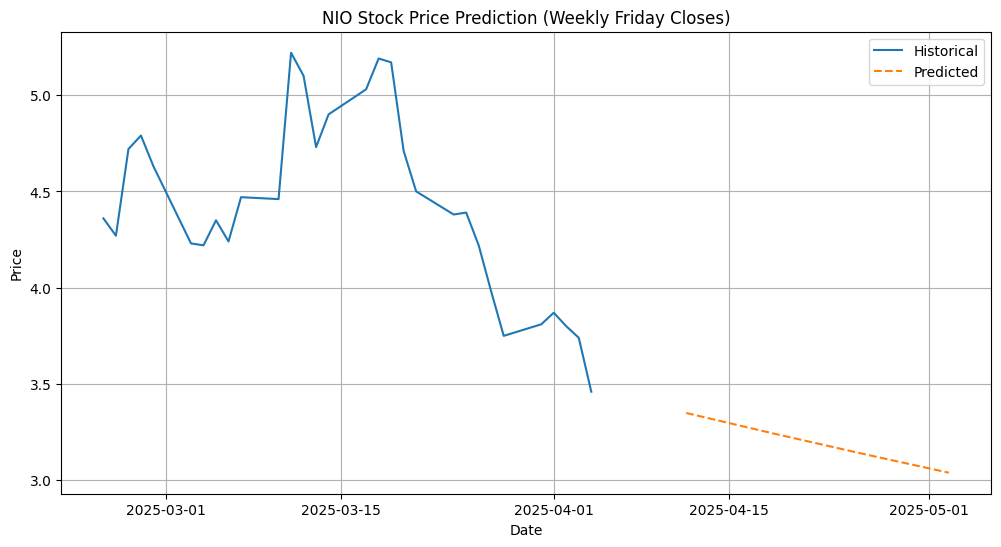


Last Known Price (as of 2025-04-04): $3.46

Predictions for upcoming Fridays:
------------------------------------------------------------
Friday 2025-04-11: $3.35 (Change: -3.19%)
Friday 2025-04-18: $3.24 (Change: -6.28%)
Friday 2025-04-25: $3.14 (Change: -9.27%)
Friday 2025-05-02: $3.04 (Change: -12.15%)
------------------------------------------------------------


/var/folders/72/_d36v57x6_5gq9xd3rh5dq9w0000gn/T/ipykernel_59689/470523673.py:115: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(stock_data['Close'].iloc[-1])


In [ ]:
def train(ticker):
    # Set date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*3)  # 3 years of data
    
    try:
        # Download and prepare data
        print(f"Downloading data for {ticker} from {start_date} to {end_date}")
        stock_data = download_stock_data(ticker, start_date, end_date)
        if stock_data.empty:
            raise ValueError(f"No data downloaded for {ticker}")
        
        print(f"Downloaded {len(stock_data)} days of data")
        
        # Handle missing values first
        stock_data = stock_data.ffill().bfill()
        enhanced_data = add_option_indicators(stock_data, ticker)
        
        # Define available features
        available_features = [
            'Open', 'High', 'Low', 'Close', 'Volume',  # OHLCV
            '1w_return', '2w_return', '1m_return', '20d_vol',  # Momentum
            'RSI', 'MACD', 'MACD_signal', 'MACD_hist',  # Technical
            'BBL', 'BBM', 'BBU',  # Bollinger Bands
            'above_200ma', 'above_50ma'  # Trend
        ]
        
        # Handle missing values
        enhanced_data = enhanced_data.ffill().bfill()
        enhanced_data = enhanced_data.dropna()
        
        if len(enhanced_data) == 0:
            raise ValueError("No valid data after preprocessing")
        
        # Select features and scale
        features = enhanced_data[available_features].values
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        
        # Create sliding windows
        window_size = 20
        X, y = create_sliding_windows(features_scaled, window_size)
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid sequences created")
        
        # Split data
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Add validation set
        val_size = int(len(X_train) * 0.2)
        X_val = X_train[-val_size:]
        y_val = y_train[-val_size:]
        X_train = X_train[:-val_size]
        y_train = y_train[:-val_size]
        
        # Model parameters
        input_size = len(available_features)
        hidden_size = 128
        num_layers = 2
        output_size = 1
        
        # Initialize model
        model = StockLSTM(input_size, hidden_size, num_layers, output_size).to(device)
        
        # Training parameters
        learning_rate = 0.0001
        num_epochs = 50
        batch_size = 32
        
        # Create data loaders
        train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), 
                                    torch.FloatTensor(y_train).to(device))
        val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device), 
                                  torch.FloatTensor(y_val).to(device))
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Optimizer with L2 regularization
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        criterion = nn.MSELoss()
        
        # Train with validation
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
        
        return model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data
        
    except Exception as e:
        print(f"Error in training: {str(e)}")
        return None, None, None, None, None, None, None


# Example usage:
base_tickers = get_high_interest_tickers(
    min_volume=500000,        # 1M daily volume
    min_option_interest=500,  # 1K option interest
    max_stocks=10             # Return top 10
)

# Add any additional tickers you want to analyze
additional_tickers = ["QS"]

# Combine and remove duplicates
tickers = list(set(base_tickers + additional_tickers))

print("\nAnalyzing these tickers:", tickers)

# Run the model for each ticker
for ticker in tickers:
    print(f"Training model for {ticker}")
    result = train(ticker)
    if result[0] is not None:
        model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data = result
        print(f"\nPredicting for {ticker}")
        predictions = predict(model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data, num_weeks=4)
        
        last_known_price = float(stock_data['Close'].iloc[-1])
        last_date = stock_data.index[-1]
        
        print(f"\nLast Known Price (as of {last_date.strftime('%Y-%m-%d')}): ${last_known_price:.2f}")
        print("\nPredictions for upcoming Fridays:")
        print("-" * 60)
        for i in range(4):
            friday_price = float(predictions['Predicted Price'].iloc[i])
            friday_date = predictions['Date'].iloc[i]
            pct_change = ((friday_price/last_known_price - 1) * 100)
            print(f"Friday {friday_date.strftime('%Y-%m-%d')}: ${friday_price:.2f} (Change: {pct_change:+.2f}%)")
        print("-" * 60)
    else:
        print(f"Skipping prediction for {ticker} due to training failure")